In [1]:
""" Main Script to evaluate a trained model """
print 


In [54]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.autograd import Variable
import numpy as np


# Universal import block 
# Block to get the relative imports working 
import os
import sys 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import math
import config
import matplotlib.pyplot as plt 
import prebuilt_loss_functions as plf
import loss_functions as lf 
import utils.pytorch_utils as utils
import utils.image_utils as img_utils
import cifar10.cifar_loader as cifar_loader
import cifar10.cifar_resnets as cifar_resnets
import adversarial_attacks as aa
import adversarial_training as advtrain
import adversarial_evaluation as adveval
import utils.checkpoints as checkpoints
import adversarial_perturbations as ap
import adversarial_attacks_refactor as aar 
import spatial_transformers as st 

In [55]:
# LOAD THE PRETRAINED (DEFENDED) MODEL (NOTE: THIS HAS TO BE RESNET32)
USE_GPU = torch.cuda.is_available()
EXPERIMENT_NAME = "pgd_linf8_lr01_iter50" #INSERT EXPERIMENT NAME HERE

classifier_net, cifar_normer = cifar_loader.load_pretrained_cifar_resnet(flavor=32, use_gpu=USE_GPU, 
                                                                    return_normalizer=True) 


defended_state_dict_file = checkpoints.params_to_filename(EXPERIMENT_NAME, 'resnet32')[-1]
print "Loading %s params into resnet32" % defended_state_dict_file 

classifier_net = checkpoints.load_state_dict_from_filename(defended_state_dict_file, classifier_net)

Loading pgd_linf8_lr01_iter50.resnet32.000032.path.tar params into resnet32


In [56]:
# LOAD THE EVALUATION DATASET 
val_loader = cifar_loader.load_cifar_data('val', normalize=False, 
                                          batch_size=128, use_gpu=USE_GPU, 
                                         shuffle=False)


Files already downloaded and verified


In [66]:
reload(adveval)
# Build various attacks to test 
L_INF_BOUND = 8.0/255.0 
FLOW_LINF = 0.01
PGD_ITER = 50 


##############################################################################
#                                                                            #
#             FGSM ONLY                                                      #
#                                                                            #
##############################################################################

def build_delta_fgsm_eval():
    delta_threat = ap.ThreatModel(ap.DeltaAddition, 
                                  ap.PerturbationParameters(lp_style='inf',
                                                            lp_bound=L_INF_BOUND, 
                                                            use_gpu=USE_GPU))
    attack_loss = plf.VanillaXentropy(classifier_net, cifar_normer)
    fgsm_attack = aar.FGSM(classifier_net, cifar_normer, delta_threat, attack_loss, use_gpu=USE_GPU)
    attack_kwargs ={'verbose': False}
    params = advtrain.AdversarialAttackParameters(fgsm_attack, 1.0, 
                                       attack_specific_params={'attack_kwargs': attack_kwargs})    
    to_eval= {'top1': 'top1',
              'lpips': 'avg_successful_lpips'}
    eval_result = adveval.EvaluationResult(params, classifier_net, cifar_normer, 
                                           to_eval=to_eval, use_gpu=USE_GPU)
    return eval_result 


##############################################################################
#                                                                            #
#        PGD LINFINITY                                                       #
#                                                                            #
##############################################################################


    
def build_delta_pgd_eval():
    # UNSIGNED PGD ATTACK 
    delta_threat = ap.ThreatModel(ap.DeltaAddition, 
                                  ap.PerturbationParameters(lp_style='inf',
                                                            lp_bound=L_INF_BOUND,
                                                            use_gpu=USE_GPU))
    attack_loss = plf.VanillaXentropy(classifier_net, cifar_normer)
    pgd_attack = aar.PGD(classifier_net, cifar_normer, delta_threat, attack_loss, use_gpu=USE_GPU)
    optimizer = optim.Adam
    optimizer_kwargs = {'lr': 0.01}
    pgd_kwargs = {'num_iterations': PGD_ITER, 
                  'signed': False, 
                  'optimizer': optimizer, 
                  'optimizer_kwargs': optimizer_kwargs, 
                  'verbose': False}      
    params = advtrain.AdversarialAttackParameters(pgd_attack, 1.0, 
                                       attack_specific_params={'attack_kwargs': pgd_kwargs})
    to_eval= {'top1': 'top1',
              'lpips': 'avg_successful_lpips'}
    
    eval_result = adveval.EvaluationResult(params, classifier_net, cifar_normer, 
                                           to_eval=to_eval, use_gpu=USE_GPU)
    return eval_result     

##############################################################################
#                                                                            #
#      PGD FLOW                                                              #
#                                                                            #
##############################################################################

def build_stadv_pgd_eval():
    # STAdv style attack 
    flow_threat = ap.ThreatModel(ap.ParameterizedXformAdv, 
                                 ap.PerturbationParameters(lp_style='inf', 
                                                           lp_bound=FLOW_LINF,
                                                           xform_class=st.FullSpatial, 
                                                           use_gpu=USE_GPU))
    adv_loss = lf.CWLossF6(classifier_net, cifar_normer)
    st_loss = lf.PerturbationNormLoss(lp=2)
    
    loss_fxn = lf.RegularizedLoss({'adv': adv_loss, 'st':st_loss}, 
                                  {'adv': 1.0, 'st': 0.05},
                                  negate=True)  
    
    optimizer = optim.Adam
    optimizer_kwargs = {'lr': 0.001}
    pgd_attack = aar.PGD(classifier_net, cifar_normer, flow_threat, loss_fxn, use_gpu=USE_GPU)
    pgd_kwargs = {'num_iterations': PGD_ITER,  
                  'signed': False, 
                  'optimizer': optimizer, 
                  'optimizer_kwargs': optimizer_kwargs, 
                  'verbose': False}    


    params = advtrain.AdversarialAttackParameters(pgd_attack, 1.0, 
                                       attack_specific_params={'attack_kwargs': pgd_kwargs})
    to_eval= {'top1': 'top1',
              'lpips': 'avg_successful_lpips'}    
    eval_result = adveval.EvaluationResult(params, classifier_net, cifar_normer, 
                                           to_eval=to_eval, use_gpu=USE_GPU)
    return eval_result  


##############################################################################
#                                                                            #
#     PGD + ROT + TRANS                                                      #
#                                                                            #
##############################################################################

def build_delta_rot_trans_pgd_eval():
    # L_inf + flow style attack 
    delta_threat = ap.ThreatModel(ap.DeltaAddition, 
                                  ap.PerturbationParameters(lp_style='inf',
                                                            lp_bound=L_INF_BOUND,
                                                            use_gpu=USE_GPU))
    trans_threat = ap.ThreatModel(ap.ParameterizedXformAdv, 
                                  ap.PerturbationParameters(lp_style=1, 
                                                            lp_bound=0.05, 
                                                            xform_class=st.TranslationTransform,
                                                            use_gpu=USE_GPU))
    rotation_threat = ap.ThreatModel(ap.ParameterizedXformAdv,
                                     ap.PerturbationParameters(xform_class=st.RotationTransform, 
                                                              lp_style='inf', lp_bound=math.pi / 24.,
                                                              use_gpu=USE_GPU))
    
    sequence_threat = ap.ThreatModel(ap.SequentialPerturbation, 
                                 [delta_threat, trans_threat, rotation_threat])

    loss_fxn = plf.VanillaXentropy(classifier_net, cifar_normer)
    optimizer = optim.Adam
    optimizer_kwargs = {'lr': 0.001}
    pgd_attack = aar.PGD(classifier_net, cifar_normer, sequence_threat, loss_fxn, use_gpu=USE_GPU)
    pgd_kwargs = {'num_iterations': PGD_ITER, 
                  'signed': False, 
                  'optimizer': optimizer, 
                  'optimizer_kwargs': optimizer_kwargs, 
                  'verbose': False}    

    params = advtrain.AdversarialAttackParameters(pgd_attack, 1.0, 
                                       attack_specific_params={'attack_kwargs': pgd_kwargs})
    to_eval= {'top1': 'top1',
              'lpips': 'avg_successful_lpips'}
    
    eval_result = adveval.EvaluationResult(params, classifier_net, cifar_normer, 
                                           to_eval=to_eval, use_gpu=USE_GPU)
    return eval_result 



##############################################################################
#                                                                            #
#    DELTA + FLOW                                                            #
#                                                                            #
##############################################################################

def build_delta_stadv_pgd_eval():
    # L_inf + flow style attack 
    delta_threat = ap.ThreatModel(ap.DeltaAddition, 
                                  ap.PerturbationParameters(lp_style='inf',
                                                            lp_bound=L_INF_BOUND, 
                                                            use_gpu=USE_GPU))
    flow_threat = ap.ThreatModel(ap.ParameterizedXformAdv, 
                                 ap.PerturbationParameters(lp_style='inf', 
                                                           lp_bound=FLOW_LINF,
                                                           xform_class=st.FullSpatial, 
                                                           use_gpu=USE_GPU))
    sequence_threat = ap.ThreatModel(ap.SequentialPerturbation, 
                                 [delta_threat, flow_threat],
                                ap.PerturbationParameters(norm_weights=[0.00, 1.00]))
    adv_loss = lf.CWLossF6(classifier_net, cifar_normer)
    st_loss = lf.PerturbationNormLoss(lp=2)
    
    loss_fxn = lf.RegularizedLoss({'adv': adv_loss, 'st':st_loss}, 
                                  {'adv': 1.0, 'st': 0.05},
                                  negate=True)
    
    optimizer = optim.Adam
    optimizer_kwargs = {'lr': 0.001}
    pgd_attack = aar.PGD(classifier_net, cifar_normer, sequence_threat, loss_fxn, use_gpu=USE_GPU)
    pgd_kwargs = {'num_iterations': PGD_ITER, 
                  'signed': False, 
                  'optimizer': optimizer, 
                  'optimizer_kwargs': optimizer_kwargs, 
                  'verbose': False}    

    params = advtrain.AdversarialAttackParameters(pgd_attack, 1.0, 
                                       attack_specific_params={'attack_kwargs': pgd_kwargs})
    to_eval= {'top1': 'top1',
              'lpips': 'avg_successful_lpips'}
    
    eval_result = adveval.EvaluationResult(params, classifier_net, cifar_normer, 
                                           to_eval=to_eval, use_gpu=USE_GPU)
    return eval_result 


fgsm = build_delta_fgsm_eval()
pgd_linf = build_delta_pgd_eval()
stadv = build_stadv_pgd_eval()
delta_rot_trans = build_delta_rot_trans_pgd_eval()
delta_stadv = build_delta_stadv_pgd_eval() 


In [67]:
def verify_eval(eval_obj, num=4):
    examples, labels = next(iter(val_loader))
    examples = examples.cuda()
    labels = labels.cuda() 
    attack_out = eval_obj.attack_params.attack(examples, labels)
    img_utils.show_images([attack_out[0][:num], examples[:num], 
                           attack_out[0][:num] - examples[:num] + 0.5])

In [68]:
# BUILD ATTACK ENSEMBLE 
ensemble = {
            'fgsm': fgsm, 
            'pgd_linf': pgd_linf,
            'stadv': stadv,
            'delta_rot_trans': delta_rot_trans, 
            'delta_stadv': delta_stadv
           }
            
eval_obj = adveval.AdversarialEvaluation(classifier_net, cifar_normer, use_gpu=USE_GPU)
eval_output = eval_obj.evaluate_ensemble(val_loader, ensemble, verbose=True, num_minibatches=3)


Starting minibatch 0...
	 (mb: 0) evaluating pgd_linf...
	 (mb: 0) evaluating fgsm...
	 (mb: 0) evaluating stadv...
	 (mb: 0) evaluating delta_rot_trans...
	 (mb: 0) evaluating delta_stadv...
	 (mb: 0) evaluating ground...
Starting minibatch 1...
	 (mb: 1) evaluating pgd_linf...
	 (mb: 1) evaluating fgsm...
	 (mb: 1) evaluating stadv...
	 (mb: 1) evaluating delta_rot_trans...
	 (mb: 1) evaluating delta_stadv...
	 (mb: 1) evaluating ground...
Starting minibatch 2...
	 (mb: 2) evaluating pgd_linf...
	 (mb: 2) evaluating fgsm...
	 (mb: 2) evaluating stadv...
	 (mb: 2) evaluating delta_rot_trans...
	 (mb: 2) evaluating delta_stadv...
	 (mb: 2) evaluating ground...


In [69]:
for k, v in eval_output.items():
    if k != 'ground':
        print k, v.results['top1'].avg, v.results['lpips']
    else:
        print k, v.results['top1'].avg

pgd_linf 0.385416666667 0.00572129084754
fgsm 0.458333333333 0.00559239363852
stadv 0.53125 6.19031167853e-14
delta_rot_trans 0.263020833333 0.0146495681382
delta_stadv 0.158854166667 6.19031167853e-14
ground 0.807291666667


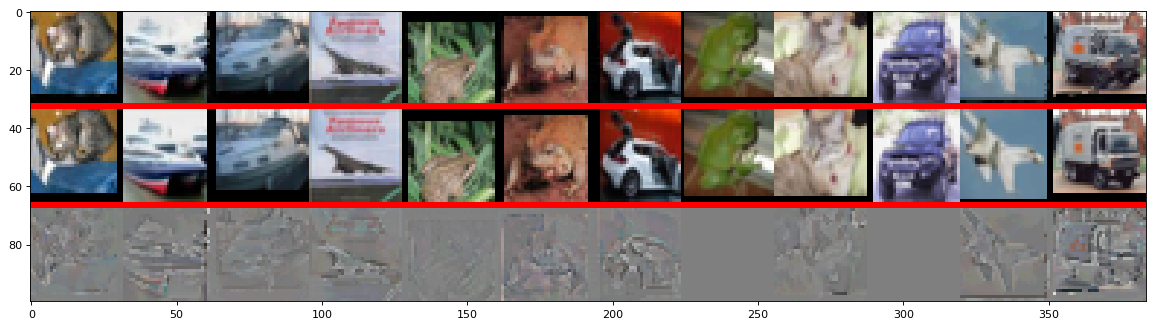

In [65]:
verify_eval(delta_stadv, num=12)
